## Event reproducibility, manifold analysis, and functional connectivity of several cortical areas

We will collect neurons from several cortical areas to perform population *dynamical* and *attractor* analysis, and get the *functional connectivity*.     
This will address three relevant points:
- Does the dynamic analysis hold at **higher temporal resolution**?
    - How do events statistics (duration and size) compare to 2-photon?
- Are population events only a **side-effect of behavior** (locomotion, whisker pad, pupil)?
    - Do behavioral components explain pattern reproducibility?
- Do **all areas of cortex** show attractor dynamics?
    - How do pattern trajectories compare to MICrONS?

To do all this, we analyse the [data](https://janelia.figshare.com/articles/dataset/Eight-probe_Neuropixels_recordings_during_spontaneous_behaviors/7739750/4) by [Stringer et al. 2019](science.org/doi/10.1126/science.aav7893).   
Eight-probe Neuropixels recordings in three mice during spontaneous activity.   

This notebook calls `dynamical_analysis.ipynb` and `attractor_analysis.ipynb`.

In [8]:
from platform import python_version
print(python_version())

%run -i 'imports_functions.py' 

%matplotlib inline

3.10.4


**WARNING**: the next cell takes time to download and unzip the neuropixel data.

In [9]:
if not os.path.exists("stringer/7739750.zip"):
    print("Downloading neuropixel data ...")
    if not os.path.exists("stringer"):
        os.makedirs("stringer")
    resp = wget.download("https://janelia.figshare.com/ndownloader/articles/7739750/versions/4", "stringer/7739750.zip")
    print("... Done: "+resp)

if not os.path.exists("stringer/7739750"):
    # unzip downloaded folder
    if os.path.exists("stringer/7739750.zip"):
        print("... unzipping")
        shutil.unpack_archive("stringer/7739750.zip", "stringer/7739750")
        shutil.unpack_archive("stringer/7739750/spks.zip", "stringer/7739750/")
        shutil.unpack_archive("stringer/7739750/faces.zip", "stringer/7739750/")
    print("Done.")
else:
    print("All data available.")

All data available.


### Data preprocessing

This analysis is based on the file `ephysLoad.m`.

Each "spks" is a structure of length 8, where each entry is a different probe (these probes were recorded simultaneously). It contains the spike times (in seconds, e.g. 4048.44929626 sec (?kHz sampling)), the cluster identity of each spike (its cell), and the height of each cluster on the probe.

The location of each site on the probe in microns in the Allen CCF framework is given in "ccfCoords". The brain area for each site is in "borders" as a function of the height of the site. 

We need the spikes from each area and probe to be separate lists. So, we build a dictionary to hold them, and save it locally as `area_spiketrains.npy`.

In [10]:
if os.path.exists("stringer/area_spiketrains.npy"):
    area_spiketrains = np.load("stringer/area_spiketrains.npy", allow_pickle=True).item()
    print("... loaded populations")
else:
    print("... collecting populations")
    
    probeLoc = sio.loadmat('stringer/7739750/probeLocations.mat')
    probeBorders = sio.loadmat('stringer/7739750/probeBorders.mat', squeeze_me=True)

    mouse_names = ['Krebs','Waksman','Robbins']
    cortical_areas = ['FrCtx','FrMoCtx','SomMoCtx','SSCtx','V1','V2','RSP']

    # first count the cells you want to take with this structure
    # then think on how you want to store the spikes... compatible with the dynamical_analysis
    area_spiketrains = {
        'Krebs' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Waksman' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Robbins' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]}
    }

    for imouse in range(len(mouse_names)):
        print(mouse_names[imouse])

        spks = sio.loadmat('stringer/7739750/spks/spks%s_Feb18.mat'%mouse_names[imouse], squeeze_me=True)

        # probe k
        # k = 7
        for k in range(8):
            print("probe",k)

            # spike times (in seconds)
            st = spks['spks'][k][0]
            # clusters
            clu = spks['spks'][k][1]
            print("clusters (cells) of the spikes",len(np.unique(clu)))
            # cluster heights (in microns)
            # (see siteCoords to convert to site location)
            Wh = spks['spks'][k][2]

            # where is the probe in the brain (consolidated labels)
            # borders are in microns
            # use Wh to determine which clusters are in which brain region
            borders = probeBorders['probeBorders'][imouse]['borders'][k]
            for j in range(len(borders)):
                population = [] # one population per border, there can be several borders
                b = borders[j]
                if b[2] not in cortical_areas:
                    continue
                print('upper border %d um, lower border %d um, area %s'%(b[0],b[1],b[2]))
                wneurons = np.logical_and(Wh>=b[1], Wh<b[0])
                nn = wneurons.sum()
                print('%d neurons in %s'%(nn,b[-1]))
                # we should not include population smaller than those in MICrONS
                if nn<10:
                    print('population too small. Rejected.')
                    continue

                cortical_neurons = np.nonzero(wneurons)[0]
                for cn in cortical_neurons:
                    cn_idxs = [i for i in range(len(clu)) if clu[i]==cn]
                    # print(cn_idxs)
                    population.append( sorted(st[cn_idxs]) )
                    
                area_spiketrains[ mouse_names[imouse] ][ b[2] ].append( population )
            print()

    # save to file
    np.save("stringer/area_spiketrains.npy", area_spiketrains)


... loaded populations


The following spiketrains will be loaded.

| mouse | probe | borders (um) | area | #neurons |
|:----|:----|:----|:---|:---|
| **Krebs** | 0 | 4000, 1100 | FrMoCtx | 5 |
|           | 1 | 4000, 1800 | FrMoCtx | 73 |
|           | 2 | 4000, 2600 | V1 | 61 |
|           | 3 | 4000, 2400 | V1 | 141 |
|           | 4 | 4000, 1800 | SomMoCtx | 65 |
|           | 5 | 4000, 2100 | SomMoCtx | 26 |
|           | 6 | 4000, 2350 | V1 | 68 |
|           | 7 | 4000, 2600 | V1 | 64 |
| **Waksman** | 0 | 4000, 1700 | FrMoCtx | 446 |
|             | 0 | 1200, 0 | FrMoCtx | 201 |
|             | 1 | 4000, 2150 | FrCtx | 31 |
|             | 2 | 4000, 2700 | V1 | 155 |
|             | 3 | 4000, 2250 | RSP | 112 |
|             | 4 | 4000, 2000 | SomMoCtx | 220 |
|             | 5 | 4000, 2600 | SSCtx | 50 |
|             | 6 | 4000, 2650 | V2 | 124 |
|             | 7 | 4000, 2850 | V1 | 96 |
| **Robbins** | 0 | 4000, 3400 | FrMoCtx | 16 |
|             | 1 | 4000, 3100 | FrMoCtx | 70 |
|             | 3 | 4000, 3550 | RSP | 10 |
|             | 4 | 4000, 3500 | SomMoCtx | 10 |


In [11]:
real_frame_duration = 0.00000001 # sec (e.g. 4048.44929626 s)
# frame_duration = 0.001 # ms (e.g. 4048.449 s)
frame_duration = 0.01 # 10ms (e.g. 4048.45 s)
local_path = os.getcwd() + '/stringer/7739750/'

#### Note
The cell below is particularly long to execute if the dynamical and attractor analyses are used. We therefore used only the first mouse 'Krebs' to perform those analyses.     
However, functional correlations and hirarchical modularity are light enough to be performed on all mice (with a good bit of patience). By commenting the sections on 



-------------------------
mouse: Krebs
area:  FrMoCtx
population: 0
    time: 129215
    cells: 73
... Dynamical Analysis
    population firing: 2.84±2.85 sp/frame
    cells firing rate: 0.04±0.20 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 3.442972371621408
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 9656
    number of events per sec: 1.8921609355771718
    events duration: 0.100±0.040
    events size: 19.000±6.684
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.19066564490349733
    cluster size threshold: 2
    Total number of clusters: 246
    # clusters (after removing those below reproducibility threshold): 246
    event color assignment
    unique color assignments
    clustered similarity map
  

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


    gathering cores from all clusters
    # cores: 56
    # non-cores: 17
    cores per cluster: 3.87±4.16 (min 0, max 18)
    others per cluster: 69.13±4.16 (min 55, max 73)
... Manifold Analysis
... Functional correlation analysis (functional structure)
    binary spiketrains
    shape: (73, 129217)
    starting functional adjacency matrix
    full adjacency matrix: (73, 73)
    checking details of best cross-correlation pairs 
    preparing vertex labels for cores and others
    Degree distributions
    Local Clustering Coefficient (cores too)
... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=56, minmax=(0.0, 160.83928571428572), mean=6.46077806122449, variance=673.1323564429833, skewness=4.554532846676578, kurtosis=21.880099967895735)
    Cut edges targeting cores: DescribeResult(nobs=56, minmax=(0.0, 222.0), mean=6.46077806122449, variance=1208.9364728622782, skewness=5.398861881042221, kurtosis=28.34319322405974)
    Cut edges sourcing from others: Describe

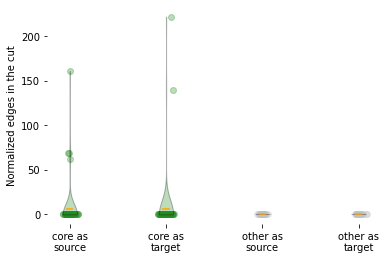

... PageRank centrality
    cores: DescribeResult(nobs=56, minmax=(0.012711864406779662, 0.10577755783743659), mean=0.017857142857142856, variance=0.00039465167992094863, skewness=3.780087138903081, kurtosis=12.685241963545044)
    others: DescribeResult(nobs=17, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  61.651 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


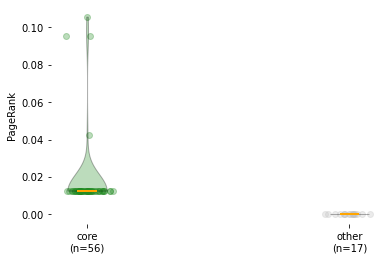

area:  SomMoCtx
population: 0
    time: 128007
    cells: 65
... Dynamical Analysis
    population firing: 3.34±2.79 sp/frame
    cells firing rate: 0.05±0.23 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.676413531624167
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 9008
    number of events per sec: 1.7618353755733103
    events duration: 0.090±0.040
    events size: 17.000±6.722
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.20754796714864582
    cluster size threshold: 2
    Total number of clusters: 179
    # clusters (after removing those below reproducibility threshold): 177
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cor

/tmp/ipykernel_53/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_53/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=47, minmax=(0.0, 8.0), mean=0.1702127659574468, variance=1.3617021276595747, skewness=6.634888026970373, kurtosis=42.02173913043479)
    Cut edges targeting cores: DescribeResult(nobs=47, minmax=(0.0, 8.0), mean=0.1702127659574468, variance=1.3617021276595747, skewness=6.634888026970373, kurtosis=42.02173913043479)
    Cut edges sourcing from others: DescribeResult(nobs=18, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=18, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  1.000 p= 0.323
    Kolmogorov-Smirnov Effect Size: 0.021


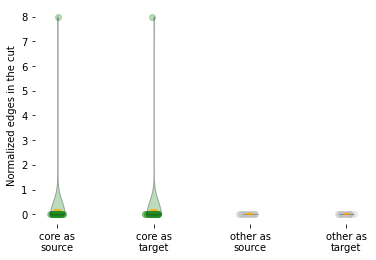

... PageRank centrality
    cores: DescribeResult(nobs=47, minmax=(0.017142857142857144, 0.11428571428571427), mean=0.021276595744680847, variance=0.0003928335441484638, skewness=4.53259797957468, kurtosis=18.544444444444483)
    others: DescribeResult(nobs=18, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  59.429 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


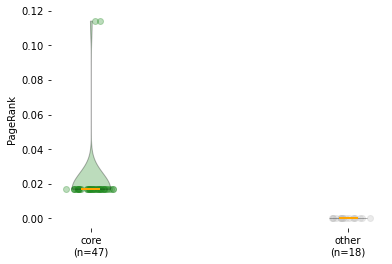

population: 1
    time: 128048
    cells: 26
... Dynamical Analysis
    population firing: 1.64±1.58 sp/frame
    cells firing rate: 0.06±0.28 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 2.2894557496176793
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 8115
    number of events per sec: 1.5881993752886745
    events duration: 0.090±0.039
    events size: 6.000±2.777
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.350415189240472
    cluster size threshold: 2
    Total number of clusters: 53
    # clusters (after removing those below reproducibility threshold): 53
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspecific

/tmp/ipykernel_53/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=13, minmax=(0.0, 90.6923076923077), mean=6.976331360946745, variance=632.6995903504779, skewness=3.175426480542943, kurtosis=8.083333333333341)
    Cut edges targeting cores: DescribeResult(nobs=13, minmax=(0.0, 90.6923076923077), mean=6.976331360946745, variance=632.6995903504779, skewness=3.175426480542943, kurtosis=8.083333333333341)
    Cut edges sourcing from others: DescribeResult(nobs=13, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=13, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  1.000 p= 0.337
    Kolmogorov-Smirnov Effect Size: 0.077


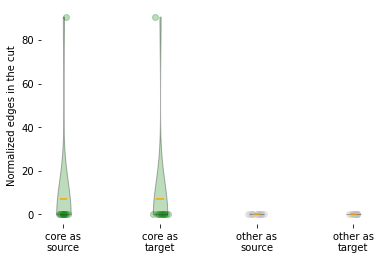

... PageRank centrality
    cores: DescribeResult(nobs=13, minmax=(0.02419354838709678, 0.3836094158674804), mean=0.07692307692307691, variance=0.016612905613313408, skewness=1.9303805082548215, kurtosis=1.7475749213810845)
    others: DescribeResult(nobs=13, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  23.462 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


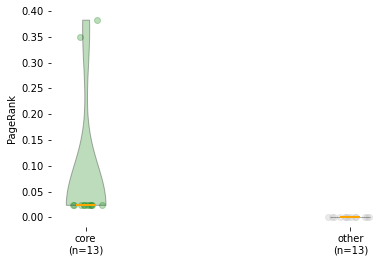

area:  V1
population: 0
    time: 129117
    cells: 61
... Dynamical Analysis
    population firing: 4.36±4.39 sp/frame
    cells firing rate: 0.07±0.30 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 5.640008670111284
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 8628
    number of events per sec: 1.6901540884568824
    events duration: 0.100±0.043
    events size: 21.000±9.341
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.1891990294759251
    cluster size threshold: 2
    Total number of clusters: 91
    # clusters (after removing those below reproducibility threshold): 91
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing

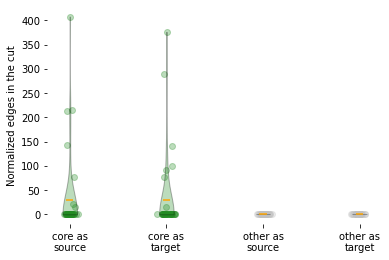

... PageRank centrality
    cores: DescribeResult(nobs=36, minmax=(0.01354321775983336, 0.10537893889250481), mean=0.027777777777777776, variance=0.000829665334966953, skewness=1.7443719327079998, kurtosis=1.300680580695274)
    others: DescribeResult(nobs=25, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  51.562 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


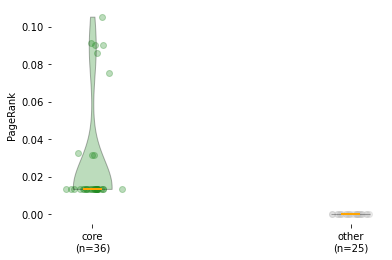

population: 1
    time: 129079
    cells: 141
... Dynamical Analysis
    population firing: 4.49±4.18 sp/frame
    cells firing rate: 0.03±0.18 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 5.958327528850128
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 7953
    number of events per sec: 1.5572560338041848
    events duration: 0.100±0.044
    events size: 27.000±15.407
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 307
    # clusters (after removing those below reproducibility threshold): 307
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspecifically
    g

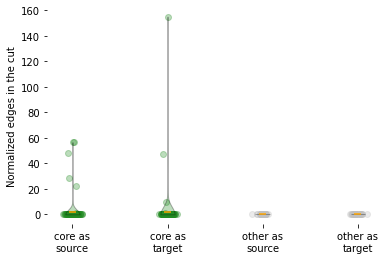

... PageRank centrality
    cores: DescribeResult(nobs=115, minmax=(0.0064655172413864825, 0.07182137924480995), mean=0.00869565217391304, variance=8.736235237763824e-05, skewness=4.541488109531978, kurtosis=21.73482913618523)
    others: DescribeResult(nobs=26, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  116.040 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


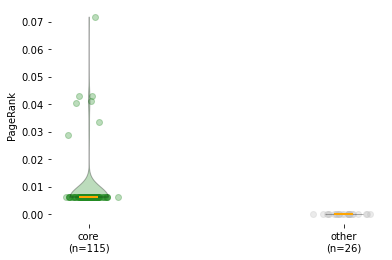

population: 2
    time: 128274
    cells: 68
... Dynamical Analysis
    population firing: 3.42±3.44 sp/frame
    cells firing rate: 0.05±0.23 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.457501364607784
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 8668
    number of events per sec: 1.6990614782697329
    events duration: 0.100±0.041
    events size: 21.000±9.166
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.18345279553233068
    cluster size threshold: 2
    Total number of clusters: 172
    # clusters (after removing those below reproducibility threshold): 171
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspec

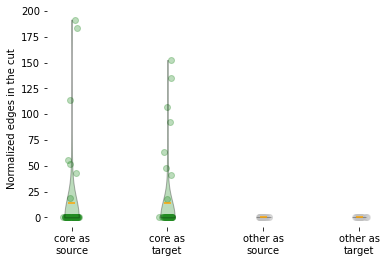

... PageRank centrality
    cores: DescribeResult(nobs=49, minmax=(0.012358246790424595, 0.11086363606055315), mean=0.02040816326530612, variance=0.00046378894663016697, skewness=3.0405986388086124, kurtosis=8.458486276742535)
    others: DescribeResult(nobs=19, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  51.260 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


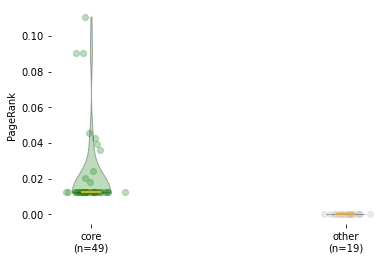

population: 3
    time: 127614
    cells: 64
... Dynamical Analysis
    population firing: 3.66±3.35 sp/frame
    cells firing rate: 0.06±0.25 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.793220374144265
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 8169
    number of events per sec: 1.6020537038053924
    events duration: 0.100±0.043
    events size: 19.000±9.040
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.19231125284303718
    cluster size threshold: 2
    Total number of clusters: 89
    # clusters (after removing those below reproducibility threshold): 89
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspecif

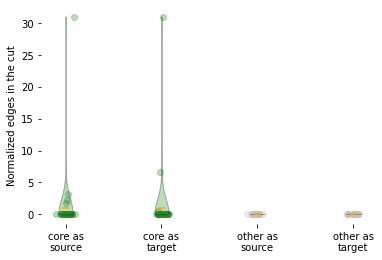

... PageRank centrality
    cores: DescribeResult(nobs=40, minmax=(0.015179934149412412, 0.10119956099608271), mean=0.025, variance=0.0005743277948009628, skewness=2.304144098538097, kurtosis=3.855586543282537)
    others: DescribeResult(nobs=24, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  54.680 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


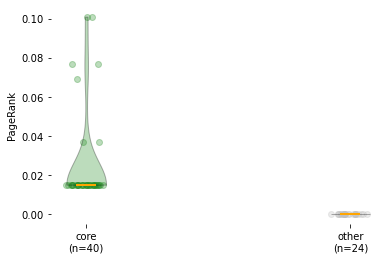




-------------------------
mouse: Waksman
area:  FrCtx
population: 0
    time: 246629
    cells: 31
... Dynamical Analysis
    population firing: 1.43±1.43 sp/frame
    cells firing rate: 0.05±0.24 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 2.3156119246438798
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 13238
    number of events per sec: 2.1704129982129095
    events duration: 0.090±0.037
    events size: 7.000±2.531
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.3179983683883768
    cluster size threshold: 2
    Total number of clusters: 135
    # clusters (after removing those below reproducibility threshold): 134
    event color assignment
    unique color assignments
    clustered similarity map
 

/tmp/ipykernel_53/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_53/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=22, minmax=(0.0, 215.45454545454547), mean=12.62809917355372, variance=2228.646130728776, skewness=3.9037352096067055, kurtosis=14.06465747003594)
    Cut edges targeting cores: DescribeResult(nobs=22, minmax=(0.0, 215.45454545454547), mean=12.62809917355372, variance=2228.646130728776, skewness=3.9037352096067055, kurtosis=14.06465747003594)
    Cut edges sourcing from others: DescribeResult(nobs=9, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=9, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  1.255 p= 0.223
    Kolmogorov-Smirnov Effect Size: 0.091


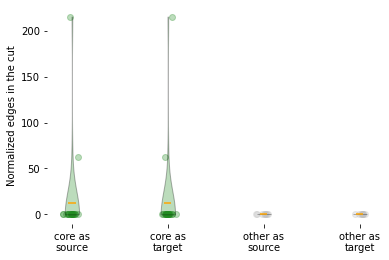

... PageRank centrality
    cores: DescribeResult(nobs=22, minmax=(0.022388059701492543, 0.14925373134328357), mean=0.04545454545454544, variance=0.0025082958921230254, skewness=1.6499158227686104, kurtosis=0.7222222222222219)
    others: DescribeResult(nobs=9, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  23.846 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


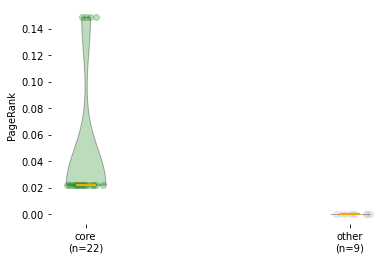

area:  FrMoCtx
population: 0
    time: 247994
    cells: 446
... Dynamical Analysis
    population firing: 10.73±4.95 sp/frame
    cells firing rate: 0.02±0.16 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 16.28404545813285
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 6292
    number of events per sec: 1.0299574888811407
    events duration: 0.100±0.044
    events size: 69.000±29.666
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 1160
    # clusters (after removing those below reproducibility threshold): 1139
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing un

/tmp/ipykernel_53/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_53/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
... PageRank centrality
population: 1
area:  SomMoCtx
population: 0
    time: 248545
    cells: 220
... Dynamical Analysis
    population firing: 9.11±5.83 sp/frame
    cells firing rate: 0.04±0.22 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 11.724195413968474
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 15235
    number of events per sec: 2.492625199810865
    events duration: 0.100±0.044
    events size: 44.000±17.171
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 549
    # clusters (after removing those below reproducibility threshold): 546
    event color assignment
    unique color assignments
    clustered similarity map

/tmp/ipykernel_53/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_53/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=218, minmax=(0.0, 7.426605504587156), mean=0.05496170356030637, variance=0.346748296044599, skewness=11.122378595021841, kurtosis=126.49177127448334)
    Cut edges targeting cores: DescribeResult(nobs=218, minmax=(0.0, 7.426605504587156), mean=0.05496170356030637, variance=0.346748296044599, skewness=11.122378595021832, kurtosis=126.4917712744834)
    Cut edges sourcing from others: DescribeResult(nobs=2, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=2, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  1.378 p= 0.170
    Kolmogorov-Smirnov Effect Size: 0.009


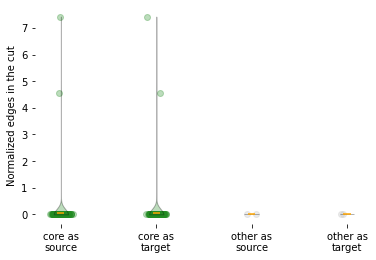

... PageRank centrality
    cores: DescribeResult(nobs=218, minmax=(0.004059539918811831, 0.03949822623690757), mean=0.004587155963302753, variance=1.298238311852213e-05, skewness=7.289615415658184, kurtosis=55.6623175223872)
    others: DescribeResult(nobs=2, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  64.019 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


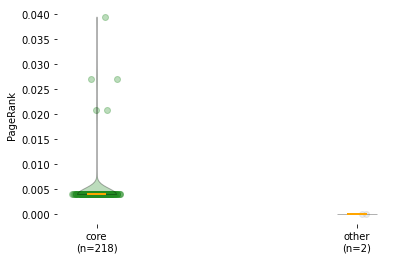

area:  SSCtx
population: 0
    time: 247713
    cells: 50
... Dynamical Analysis
    population firing: 3.01±2.90 sp/frame
    cells firing rate: 0.06±0.26 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.67520916602476
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 11336
    number of events per sec: 1.8561332957827656
    events duration: 0.100±0.042
    events size: 14.000±6.218
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.21953825673565244
    cluster size threshold: 2
    Total number of clusters: 156
    # clusters (after removing those below reproducibility threshold): 156
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores 

/tmp/ipykernel_53/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_53/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=36, minmax=(0.0, 89.86111111111111), mean=3.293981481481482, variance=243.1249724426808, skewness=5.075042753066601, kurtosis=25.130103463213825)
    Cut edges targeting cores: DescribeResult(nobs=36, minmax=(0.0, 89.86111111111111), mean=3.293981481481482, variance=243.1249724426808, skewness=5.075042753066601, kurtosis=25.130103463213825)
    Cut edges sourcing from others: DescribeResult(nobs=14, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=14, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  1.268 p= 0.213
    Kolmogorov-Smirnov Effect Size: 0.056


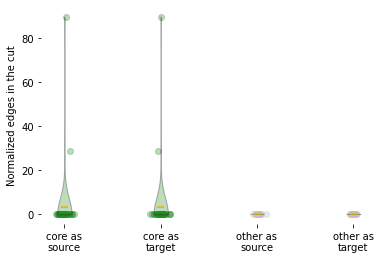

... PageRank centrality
    cores: DescribeResult(nobs=36, minmax=(0.017045454545454548, 0.11363636363636362), mean=0.027777777777777783, variance=0.0009477895841532204, skewness=2.4748737341529146, kurtosis=4.124999999999995)
    others: DescribeResult(nobs=14, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  41.425 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


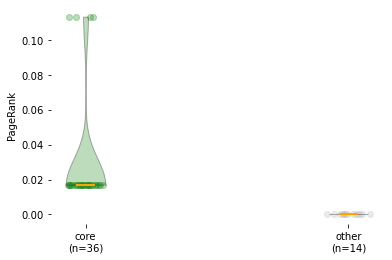

area:  V1
population: 0
    time: 246589
    cells: 155
... Dynamical Analysis
    population firing: 8.40±6.73 sp/frame
    cells firing rate: 0.05±0.25 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 10.694989974004564
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 17801
    number of events per sec: 2.917488871552476
    events duration: 0.100±0.044
    events size: 39.000±16.418
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 275
    # clusters (after removing those below reproducibility threshold): 275
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspecifi

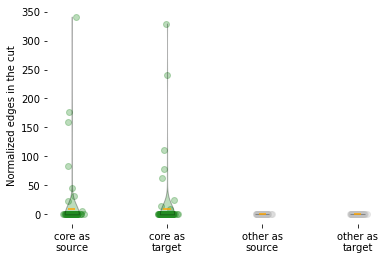

... PageRank centrality
    cores: DescribeResult(nobs=103, minmax=(0.00649350649351517, 0.08659710789710888), mean=0.009708737864077674, variance=0.00015035768530157037, skewness=4.33496670634006, kurtosis=19.501470935318796)
    others: DescribeResult(nobs=52, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  139.335 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


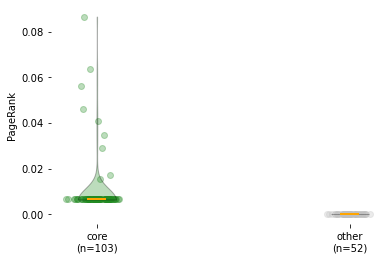

population: 1
    time: 244404
    cells: 96
... Dynamical Analysis
    population firing: 5.45±5.80 sp/frame
    cells firing rate: 0.06±0.27 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 6.780072045325212
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 14466
    number of events per sec: 2.3740167753349075
    events duration: 0.110±0.048
    events size: 22.000±13.144
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.1591759317292575
    cluster size threshold: 2
    Total number of clusters: 86
    # clusters (after removing those below reproducibility threshold): 86
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspeci

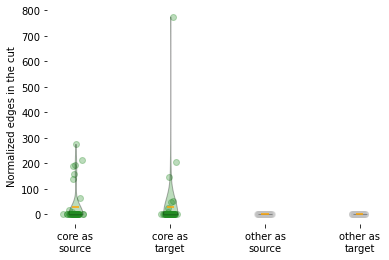

... PageRank centrality
    cores: DescribeResult(nobs=42, minmax=(0.01075268817204301, 0.1345470620760974), mean=0.023809523809523808, variance=0.0009366401865128424, skewness=2.2452909934125755, kurtosis=3.856734981042277)
    others: DescribeResult(nobs=54, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  90.198 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


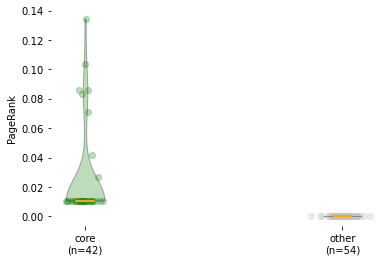

area:  V2
population: 0
    time: 245631
    cells: 124
... Dynamical Analysis
    population firing: 7.21±5.21 sp/frame
    cells firing rate: 0.06±0.27 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 9.866594351771742
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 14614
    number of events per sec: 2.396672800207294
    events duration: 0.100±0.047
    events size: 33.000±12.528
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.1379847735236924
    cluster size threshold: 2
    Total number of clusters: 215
    # clusters (after removing those below reproducibility threshold): 213
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores fi

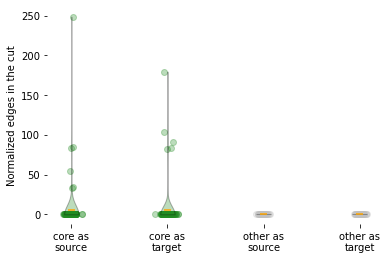

... PageRank centrality
    cores: DescribeResult(nobs=96, minmax=(0.007692307692307693, 0.06798821616339865), mean=0.010416666666666666, variance=0.00014424408553566692, skewness=4.301780924074787, kurtosis=16.878811783230958)
    others: DescribeResult(nobs=28, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  108.738 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


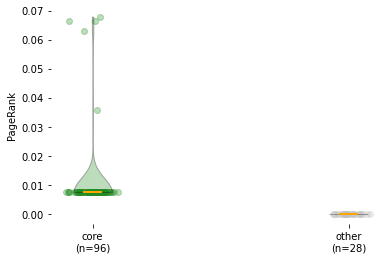

area:  RSP
population: 0
    time: 246567
    cells: 112
... Dynamical Analysis
    population firing: 9.86±7.63 sp/frame
    cells firing rate: 0.09±0.31 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 11.713855869650864
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 20150
    number of events per sec: 3.300940972950304
    events duration: 0.100±0.044
    events size: 50.000±18.287
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.13759007693534073
    cluster size threshold: 2
    Total number of clusters: 183
    # clusters (after removing those below reproducibility threshold): 183
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores

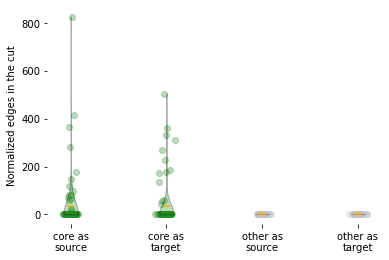

... PageRank centrality
    cores: DescribeResult(nobs=78, minmax=(0.005936378970152046, 0.09600688370522194), mean=0.01282051282051282, variance=0.000296085244239731, skewness=3.0061247173806906, kurtosis=9.050331068346676)
    others: DescribeResult(nobs=34, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  86.039 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


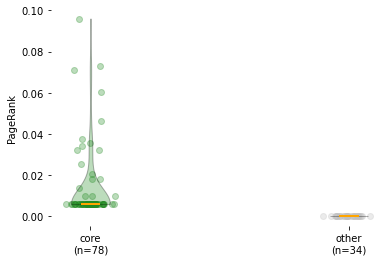




-------------------------
mouse: Robbins
area:  FrMoCtx
population: 0
    time: 220719
    cells: 16
... Dynamical Analysis
    population firing: 1.03±1.09 sp/frame
    cells firing rate: 0.06±0.26 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 2.1894241024512153
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 6068
    number of events per sec: 1.0990404225183745
    events duration: 0.090±0.038
    events size: 5.000±1.985
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.37537057619222297
    cluster size threshold: 2
    Total number of clusters: 36
    # clusters (after removing those below reproducibility threshold): 36
    event color assignment
    unique color assignments
    clustered similarity map
 

/tmp/ipykernel_53/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=7, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting cores: DescribeResult(nobs=7, minmax=(0.0, 500.14285714285717), mean=71.44897959183673, variance=35734.69679300291, skewness=2.041241452319315, kurtosis=2.166666666666667)
    Cut edges sourcing from others: DescribeResult(nobs=9, minmax=(0.0, 410.77777777777777), mean=45.641975308641975, variance=18748.709190672154, skewness=2.4748737341529163, kurtosis=4.124999999999998)
    Cut edges targeting others: DescribeResult(nobs=9, minmax=(0.0, 21.77777777777778), mean=2.419753086419753, variance=52.69684499314129, skewness=2.4748737341529163, kurtosis=4.125)
    Core targets vs sources Welch t test:  1.000 p= 0.356
    Kolmogorov-Smirnov Effect Size: 0.143
    Core targets vs Other targets Welch t test:  0.966 p= 0.371
    Kolmogorov-Smirnov Effect Size: 0.143


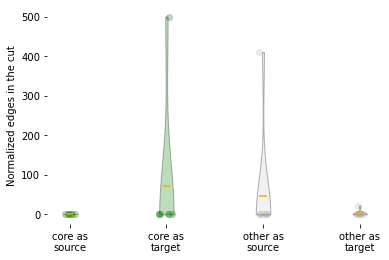

... PageRank centrality
    cores: DescribeResult(nobs=7, minmax=(0.07894736842105265, 0.18172119487908964), mean=0.09362934362934365, variance=0.0015089227721181004, skewness=2.0412414523193156, kurtosis=2.166666666666667)
    others: DescribeResult(nobs=9, minmax=(0.0, 0.2418207681365576), mean=0.038288288288288286, variance=0.006980725765819723, skewness=1.8882629066341838, kurtosis=2.04549285929662)
    Kruskal-Wallis test:  4.427 p= 0.035
    Kolmogorov-Smirnov Effect Size: 0.778


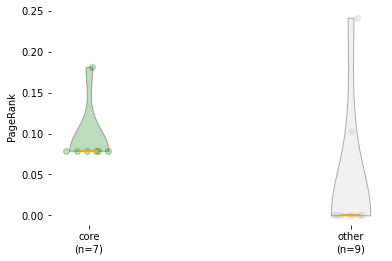

population: 1
    time: 220433
    cells: 70
... Dynamical Analysis
    population firing: 2.80±1.98 sp/frame
    cells firing rate: 0.04±0.20 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.0471063827529585
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 12048
    number of events per sec: 2.1797103127363253
    events duration: 0.080±0.038
    events size: 18.000±5.258
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.19402184281119636
    cluster size threshold: 2
    Total number of clusters: 155
    # clusters (after removing those below reproducibility threshold): 155
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unsp

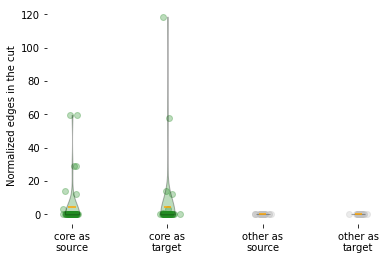

... PageRank centrality
    cores: DescribeResult(nobs=46, minmax=(0.011568327082562994, 0.11313387903803215), mean=0.021739130434782605, variance=0.0005569507511374203, skewness=2.3961564044516144, kurtosis=4.801401180035322)
    others: DescribeResult(nobs=24, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  56.627 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


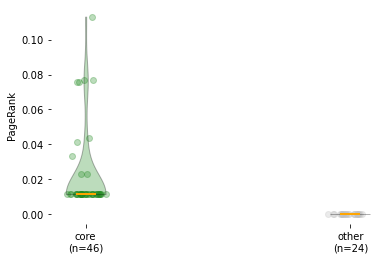

area:  SomMoCtx
population: 0
    time: 220727
    cells: 10
... Dynamical Analysis
    population firing: 0.53±0.79 sp/frame
    cells firing rate: 0.05±0.25 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 1.0477701165690312
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 4569
    number of events per sec: 0.8279828858166478
    events duration: 0.090±0.039
    events size: 3.000±1.046
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.43354545395998695
    cluster size threshold: 2
    Total number of clusters: 14
    # clusters (after removing those below reproducibility threshold): 14
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores

/tmp/ipykernel_53/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_53/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=5, minmax=(0.0, 216.0), mean=43.2, variance=9331.2, skewness=1.5, kurtosis=0.25)
    Cut edges targeting cores: DescribeResult(nobs=5, minmax=(0.0, 128.6), mean=25.72, variance=3307.5919999999996, skewness=1.4999999999999998, kurtosis=0.24999999999999956)
    Cut edges sourcing from others: DescribeResult(nobs=5, minmax=(0.0, 105.6), mean=25.72, variance=2093.192, skewness=1.3385977709737866, kurtosis=-0.0024449271504254355)
    Cut edges targeting others: DescribeResult(nobs=5, minmax=(0.0, 216.0), mean=43.2, variance=9331.2, skewness=1.5, kurtosis=0.24999999999999956)
    Core targets vs sources Welch t test:  -0.348 p= 0.739
    Kolmogorov-Smirnov Effect Size: 0.200
    Core targets vs Other targets Welch t test:  -0.348 p= 0.739
    Kolmogorov-Smirnov Effect Size: 0.200


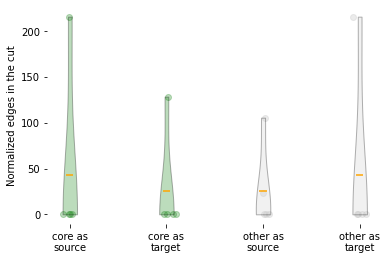

... PageRank centrality
    cores: DescribeResult(nobs=5, minmax=(0.09375000000000003, 0.33783783783783783), mean=0.14256756756756758, variance=0.01191577451607012, skewness=1.5000000000000004, kurtosis=0.25000000000000133)
    others: DescribeResult(nobs=5, minmax=(0.0, 0.14358108108108109), mean=0.057432432432432436, variance=0.006184658053323595, skewness=0.408248290463863, kurtosis=-1.8333333333333335)
    Kruskal-Wallis test:  0.972 p= 0.324
    Kolmogorov-Smirnov Effect Size: 0.600


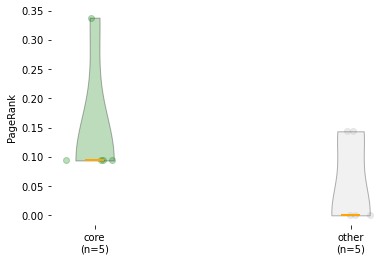

area:  RSP
population: 0
    time: 220348
    cells: 10
... Dynamical Analysis
    population firing: 0.75±0.87 sp/frame
    cells firing rate: 0.07±0.28 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 1.118779691932134
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 15583
    number of events per sec: 2.816618828309703
    events duration: 0.080±0.035
    events size: 3.000±1.358
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.41838730485283165
    cluster size threshold: 2
    Total number of clusters: 16
    # clusters (after removing those below reproducibility threshold): 16
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firin

/tmp/ipykernel_53/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_53/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
    Cut edges sourcing from cores: DescribeResult(nobs=6, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting cores: DescribeResult(nobs=6, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges sourcing from others: DescribeResult(nobs=4, minmax=(0.0, 2.75), mean=0.6875, variance=1.890625, skewness=1.1547005383792515, kurtosis=-0.6666666666666665)
    Cut edges targeting others: DescribeResult(nobs=4, minmax=(0.0, 2.75), mean=0.6875, variance=1.890625, skewness=1.1547005383792515, kurtosis=-0.6666666666666665)
    Core targets vs sources Welch t test:  nan p= nan
    Kolmogorov-Smirnov Effect Size: 0.000
    Core targets vs Other targets Welch t test:  -1.000 p= 0.391
    Kolmogorov-Smirnov Effect Size: 0.250


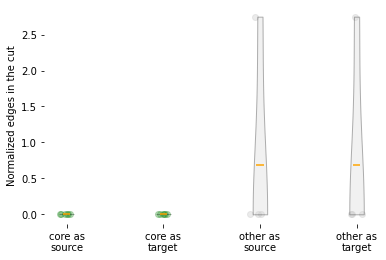

... PageRank centrality
    cores: DescribeResult(nobs=6, minmax=(0.16666666666666666, 0.16666666666666666), mean=0.16666666666666666, variance=0.0, skewness=0.0, kurtosis=-3.0)
    others: DescribeResult(nobs=4, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  9.000 p= 0.003
    Kolmogorov-Smirnov Effect Size: 1.000


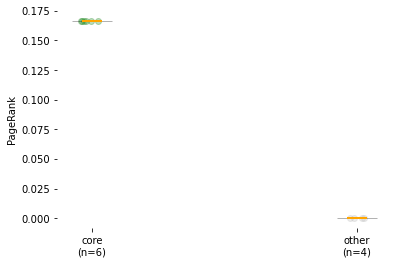

In [12]:
# start of spontaneous activity in each mouse (in seconds)
etstart = [3811, 3633, 3323]

all_degrees = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_local_clustering_coefficients = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_core_local_clustering_coefficients = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_pagerank_cores = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }
all_pagerank_others = { 'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[] }

for imouse,(mousename,areas) in enumerate(area_spiketrains.items()):
    print("\n\n-------------------------\nmouse:",mousename)
    
    # # to reduce computations, use comments here
    # if mousename not in ["Krebs", "Waksman"]:
    #     continue
    # if mousename not in ["Waksman","Robbins"]:
    #     continue
    # if mousename not in ["Robbins"]:
    #     continue
    # if mousename not in ["Waksman"]:
    #     continue
        
    exp_path = local_path + '%s/'%mousename
    exp_tstart = etstart[imouse]

    # reading behavior data to make statistics about event dependence on it
    # we will use the field 'stimulus' to store the avg motSVD of the frames 
    # The behavioral file is the processed version of a mouse face movie (time x pixels x pixels). 
    faces = sio.loadmat('stringer/7739750/faces/%s_face_proc.mat'%mousename, squeeze_me=True)
    video_timestamps = faces['times'] # same temporal resolution of ephy
    motSVD = faces['motionSVD']
    exp_istart = (np.abs(video_timestamps - exp_tstart)).argmin()    
    motSVD_1c = motSVD[:,0] # only first component
    motSVD_1c[motSVD_1c < -4000] = np.mean(motSVD_1c) # corrections
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(video_timestamps[exp_istart:], motSVD_1c[exp_istart:], linewidth=0.5, color='k')
    fig.savefig(exp_path+"/motSVD_%s.png"%mousename, transparent=True, dpi=900)
    plt.close()
    fig.clear()
    fig.clf()

    for area,probe_populations in areas.items():
        if len(probe_populations)>0:
            print("area: ",area)
            
            # # to reduce computations, use comments here
            # if area not in ['FrCtx', 'FrMoCtx']:
            # if area not in ['V1']:
            #     continue
                                                
            for ipop,spiketrains in enumerate(probe_populations): 
                print("population:",ipop)

                if mousename=='Waksman' and area=='FrMoCtx' and ipop==1:
                    continue # no events

                # rounding to ms
                # spiketrains = [np.round(sp, 3) for sp in spiketrains] # ms
                spiketrains = [np.round(sp, 2) for sp in spiketrains] # 10ms
                start_time = min([min(st) if len(st) else 0 for st in spiketrains])
                stop_time = max([max(st) if len(st) else 0 for st in spiketrains])
                time = np.arange(start_time,stop_time,frame_duration)
                print("    time:", len(time))
                print("    cells:", len(spiketrains))

                fig = plt.figure(figsize=[12.8,4.8])
                for row,train in enumerate(spiketrains):
                    plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
                plt.ylabel("cell IDs")
                plt.xlabel("time (s)")
                # plt.show()
                fig.savefig(exp_path+'%s_%s_rasterplot.png'%(area,ipop), transparent=False, dpi=800)
                plt.tight_layout()
                plt.close()
                
                ophys_cell_ids = list(range(len(spiketrains)))
                ophys_cell_indexes = ophys_cell_ids # here is an alias

                scan_spiketrains = spiketrains
                scan_id = '_%s_%s'%(area,ipop)
                
                # --------------------------------------------------------------------------
                print("... Dynamical Analysis")
                core_reproducibility_perc = 99 # threshold for detecting cores
                %run "dynamical_analysis.ipynb"
                
                # # Match smooth motion energy curve with the cluster it belongs to
                # # Count the number of events belonging to a pattern before and after the change.
                # ccolors,ccounts = np.unique(cluster_color_array, return_counts=True)
                # cluster_events_counts = dict(zip(ccolors,ccounts))
                # Npre_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # Npost_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # for sni in smoothed_beh_indices:
                #     snitime = exp_tstart + sni * frame_duration
                #     snitime_pre = snitime - 0.15 # s
                #     snitime_post = snitime + 0.15 # s
                #     for ievent,(event,ecolor) in enumerate(zip(events,cluster_color_array)):
                #         event_start_time = exp_tstart + event['start'] * frame_duration
                #         if snitime_pre < event_start_time and event_start_time < snitime:
                #             Npre_beh_cluster[ecolor] += 1
                #         if snitime < event_start_time and event_start_time < snitime_post:
                #             Npost_beh_cluster[ecolor] += 1
                # # detail
                # fig = plt.figure()
                # plt.scatter(range(len(Npre_beh_cluster.keys())), Npre_beh_cluster.values(), marker='<', c=list(Npre_beh_cluster.keys()), edgecolors=list(Npre_beh_cluster.keys()), s=1)
                # plt.scatter(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), marker='>', c=list(Npost_beh_cluster.keys()), edgecolors='none', s=1)
                # plt.vlines(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), Npre_beh_cluster.values(), colors=list(Npost_beh_cluster.keys()), linewidths=0.6)
                # plt.ylabel('occurrence')
                # plt.xlabel('Patterns')
                # fig.savefig(exp_path+"/results/Pattern_behavior_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                # # summary
                # Nsame = 0
                # Npost = 0
                # Npre = 0
                # for pre,post in zip(Npre_beh_cluster.values(),Npost_beh_cluster.values()):
                #     if pre==post: Nsame +=1
                #     if pre>post: Npre +=1
                #     if pre<post: Npost +=1
                # fig = plt.figure()
                # plt.bar([0,1,2], [Npre,Nsame,Npost], width=0.8, color='C0')
                # plt.ylabel('occurrences')
                # plt.xlabel('pattern timing relative to movement')
                # plt.xticks(range(3),['before','same','after'])
                # fig.savefig(exp_path+"/results/Pattern_behavior_summary_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()

                # --------------------------------------------------------------------------
                # Functional structure analysis
                # separated by cortical area, color: pagerank, modularity
                perc_corr = 0.6
                %run "functional_analysis.ipynb"
                all_degrees[area].extend(degrees)
                all_local_clustering_coefficients[area].extend(local_clustering_coefficients)
                all_core_local_clustering_coefficients[area].extend(core_local_clustering_coefficients)
                all_pagerank_cores[area].extend(pagerank_cores)
                all_pagerank_others[area].extend(pagerank_others)
                
                # --------------------------------------------------------------------------
                # dimensional reduction, trajectories, and manifold analysis
                print("... Manifold Analysis")
                %run "attractor_analysis.ipynb"
                
    gc.collect()
    print()    

... area: FrCtx
    Total modularity


/tmp/ipykernel_53/2398682541.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


    Total PageRank centrality
    cores: DescribeResult(nobs=22, minmax=(0.022388059701492543, 0.14925373134328357), mean=0.04545454545454544, variance=0.0025082958921230254, skewness=1.6499158227686104, kurtosis=0.7222222222222219)
    others: DescribeResult(nobs=9, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  23.846 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


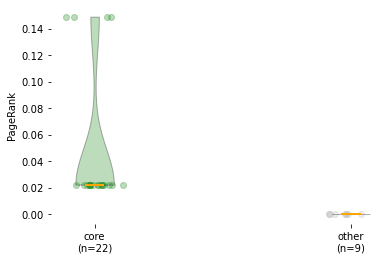

... area: FrMoCtx
    Total modularity
    Total PageRank centrality
    cores: DescribeResult(nobs=555, minmax=(0.002186588921283099, 0.18172119487908964), mean=0.006586316045775505, variance=0.00024414402838631566, skewness=6.033180022488853, kurtosis=44.20976544288051)
    others: DescribeResult(nobs=50, minmax=(0.0, 0.2418207681365576), mean=0.006891891891891892, variance=0.0013605068288674526, skewness=5.682249693425461, kurtosis=32.22271644139283)
    Kruskal-Wallis test:  192.792 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.960


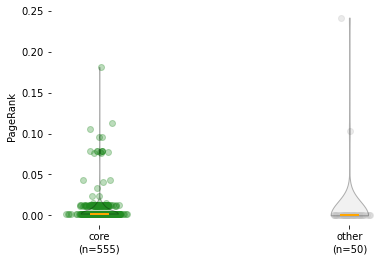

... area: SomMoCtx
    Total modularity
    Total PageRank centrality
    cores: DescribeResult(nobs=283, minmax=(0.004059539918811831, 0.3836094158674804), mean=0.013119568331582466, variance=0.0015021597202684997, skewness=7.777511905400478, kurtosis=65.22399952750797)
    others: DescribeResult(nobs=38, minmax=(0.0, 0.14358108108108109), mean=0.0075568990042674256, variance=0.0010557026549058767, skewness=4.006938426723768, kurtosis=14.055555555555554)
    Kruskal-Wallis test:  114.277 p= 0.000
    Kolmogorov-Smirnov Effect Size: 0.947


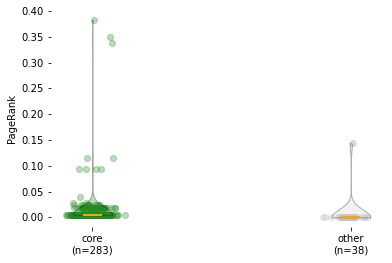

... area: SSCtx
    Total modularity
    Total PageRank centrality
    cores: DescribeResult(nobs=36, minmax=(0.017045454545454548, 0.11363636363636362), mean=0.027777777777777783, variance=0.0009477895841532204, skewness=2.4748737341529146, kurtosis=4.124999999999995)
    others: DescribeResult(nobs=14, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  41.425 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


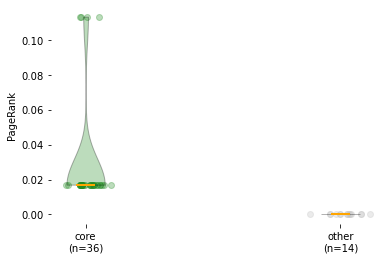

... area: V1
    Total modularity
    Total PageRank centrality
    cores: DescribeResult(nobs=385, minmax=(0.0064655172413864825, 0.1345470620760974), mean=0.015584415584415584, variance=0.0004148185970371649, skewness=3.2405651813959593, kurtosis=10.344109811932238)
    others: DescribeResult(nobs=200, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  415.456 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


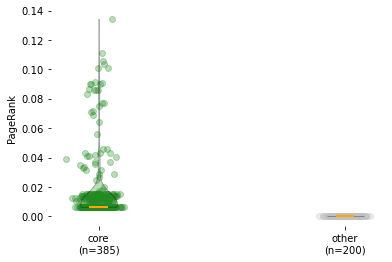

... area: V2
    Total modularity
    Total PageRank centrality
    cores: DescribeResult(nobs=96, minmax=(0.007692307692307693, 0.06798821616339865), mean=0.010416666666666666, variance=0.00014424408553566692, skewness=4.301780924074787, kurtosis=16.878811783230958)
    others: DescribeResult(nobs=28, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  108.738 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


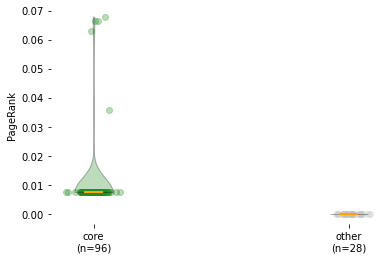

... area: RSP
    Total modularity
    Total PageRank centrality
    cores: DescribeResult(nobs=84, minmax=(0.005936378970152046, 0.16666666666666666), mean=0.023809523809523808, variance=0.00186345416475411, skewness=2.6834385573438713, kurtosis=5.938069395892212)
    others: DescribeResult(nobs=38, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  91.512 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


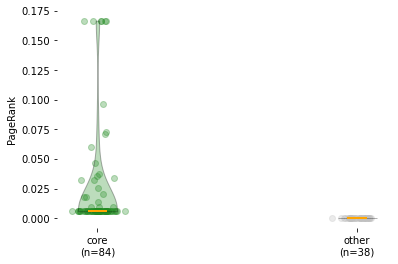

In [20]:
cortical_areas = ['FrCtx','FrMoCtx','SomMoCtx','SSCtx','V1','V2','RSP']
cortical_colors = ['tab:olive', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:brown']
# summary figures
for area,acolor in zip(cortical_areas,cortical_colors):
    print("... area:",area)
    # modularity
    print('    Total modularity')
    # figure
    fig, (hmmap, chist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 1]})
    # hierarchy
    hmmap.scatter( all_degrees[area], all_local_clustering_coefficients[area], marker='o', facecolor=acolor, s=50, edgecolors='none', alpha=0.5) 
    hmmap.set_yscale('log')
    hmmap.set_ylim([0.09,1.1])
    hmmap.set_xscale('log')
    hmmap.set_xlim([0.5,20])
    hmmap.spines['top'].set_visible(False)
    hmmap.spines['right'].set_visible(False)
    hmmap.set_ylabel('LCC')
    hmmap.set_xlabel('degree')
    hmmap.tick_params(axis='both', bottom='on', top='on', left='off', right='off')
    # core lcc histogram
    bins = np.linspace(0.02,0.9,50)
    barheight = (max(all_local_clustering_coefficients[area])-min(all_local_clustering_coefficients[area]))/50
    lcc_hist, lcc_binedges = np.histogram(all_core_local_clustering_coefficients[area], bins)
    chist.barh(bins[:-1], lcc_hist, height=barheight, align='center', color='green', linewidth=0)
    chist.spines['top'].set_visible(False)
    chist.spines['right'].set_visible(False)
    chist.tick_params(axis='x', which='both', bottom=True, top=False, labelsize='x-small')
    chist.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    chist_ticks = chist.get_xticks()
    chist.set_ylim([0.01,1.1])
    chist.set_ylabel('LCC')
    chist.set_xlabel('count')
    chist.yaxis.set_label_position("right")
    chist.spines['top'].set_visible(False)
    chist.spines['right'].set_visible(False)
    chist.spines['bottom'].set_visible(False)
    plt.tight_layout()
    fig.savefig("stringer/7739750/cores_hierarchical_modularity_%s.svg"%(area), transparent=True)
    plt.close()
    fig.clear()
    fig.clf()

    # totals
    if len(all_pagerank_cores[area])>0 and len(all_pagerank_others[area])>0:
        print('    Total PageRank centrality')
        # description
        print("    cores: "+str(stats.describe(all_pagerank_cores[area])) )
        print("    others: "+str(stats.describe(all_pagerank_others[area])) )
        # significativity
        print("    Kruskal-Wallis test:  %.3f p= %.3f" % stats.kruskal(all_pagerank_cores[area], all_pagerank_others[area]))
        d,_ = stats.ks_2samp(all_pagerank_cores[area], all_pagerank_others[area]) # non-parametric measure of effect size [0,1]
        print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

        fig, ax = plt.subplots()
        xs = np.random.normal(1, 0.04, len(all_pagerank_cores[area]))
        plt.scatter(xs, all_pagerank_cores[area], alpha=0.3, c='forestgreen')
        xs = np.random.normal(2, 0.04, len(all_pagerank_others[area]))
        plt.scatter(xs, all_pagerank_others[area], alpha=0.3, c='silver')
        vp = ax.violinplot([all_pagerank_cores[area],all_pagerank_others[area]], widths=0.15, showextrema=False, showmedians=True)
        for pc in vp['bodies']:
            pc.set_edgecolor('black')
        for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
            pc.set_facecolor(cb)
        vp['cmedians'].set_color('orange')
        vp['cmedians'].set_linewidth(2.)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.ylabel('PageRank')
        plt.xticks([1, 2], ["core\n(n={:d})".format(len(all_pagerank_cores[area])), "other\n(n={:d})".format(len(all_pagerank_others[area]))])
        fig.savefig("stringer/7739750/global_cores_others_pagerank_all_%s.svg"%(area), transparent=True)
        plt.show()
